In [6]:
import os

print(os.getcwd())

/Users/jasperverbeet/Projects/byont/easylog-python-server/apps/api/experiments


In [43]:
import io
import json
import zipfile

from adobe.pdfservices.operation.auth.service_principal_credentials import ServicePrincipalCredentials
from adobe.pdfservices.operation.io.cloud_asset import CloudAsset
from adobe.pdfservices.operation.io.stream_asset import StreamAsset
from adobe.pdfservices.operation.pdf_services import PDFServices
from adobe.pdfservices.operation.pdf_services_media_type import PDFServicesMediaType
from adobe.pdfservices.operation.pdfjobs.jobs.extract_pdf_job import ExtractPDFJob
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_element_type import ExtractElementType
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_pdf_params import ExtractPDFParams
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_renditions_element_type import (
    ExtractRenditionsElementType,
)
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.table_structure_type import TableStructureType
from adobe.pdfservices.operation.pdfjobs.result.extract_pdf_result import ExtractPDFResult


def load_pdf_service_credentials() -> dict:
    with open("pdfservices-api-credentials.json") as cred_file:
        data = json.load(cred_file)
    return data["client_credentials"]


# Open en lees het input PDF-bestand
with open("./tmp/files/example.pdf", "rb") as file:
    input_stream = file.read()

# Lees de credentials uit het JSON bestand
creds = load_pdf_service_credentials()
credentials = ServicePrincipalCredentials(
    client_id=creds["client_id"],
    client_secret=creds["client_secret"]
)

# Maak een instantie van de PDF Services
pdf_services = PDFServices(credentials=credentials)

# Upload het bronbestand als een asset
input_asset = pdf_services.upload(
    input_stream=input_stream,
    mime_type=PDFServicesMediaType.PDF
)

# Stel de parameters in voor de extractie
extract_pdf_params = ExtractPDFParams(
    table_structure_type=TableStructureType.XLSX,
    elements_to_extract=[
        ExtractElementType.TEXT,
        ExtractElementType.TABLES,
    ],
    elements_to_extract_renditions=[ExtractRenditionsElementType.FIGURES],
)

# Maak en verstuur de extractiejob
extract_pdf_job = ExtractPDFJob(
    input_asset=input_asset,
    extract_pdf_params=extract_pdf_params
)
location = pdf_services.submit(extract_pdf_job)
pdf_services_response = pdf_services.get_job_result(location, ExtractPDFResult)

result_asset: CloudAsset = pdf_services_response.get_result().get_resource()
stream_asset: StreamAsset = pdf_services.get_content(result_asset)


# Get the zip content
zip_content = stream_asset.get_input_stream()

zf=zipfile.ZipFile(io.BytesIO(zip_content))


Table contents:
{'• SCHUUR ROL SCOTCH BRITE ROOD AVF _x000D__x000D_• LIJM 50ML 542 HYDR/PNEUM LOCTITE _x000D__x000D_• VASELINE ZUURVRIJ _x000D__x000D_• VET 1KG LONGTERM 2 PLUS MOLYKOTE _x000D__x000D_• VET LOCTITE LB 8014 _x000D__x000D_• VULPLAAT 30X25X1 STANG ROLSTAB M5 (naar behoefte) _x000D__x000D_• VULPLAAT 30X25X2 STANG ROLSTAB M5 (naar behoefte) _x000D__x000D_• DOP LUCHTKOPPELING KNST M16 _x000D__x000D_• DOP LUCHTKOPPELING KNST G3/8 _x000D__x000D_• DOP LUCHTKOPPELING KNST G1/2 _x000D__x000D_• DOP 26,5X24,2X28 PLAST NATUREL _x000D__x000D_• PASTA MONTAGE MOLYKOTE 1000 BLIK  250gr _x000D__x000D_• VET CONTACTAL HPG PATROON 200G 15G _x000D__x000D_• REIN.MIDDEL 500ML CB100 _x000D__x000D_• SCHUUR ROL SCOTCH BRITE ROOD AVF _x000D__x000D_• VERF MARKEER ECRIMETAL ROOD _x000D__x000D__x000D_': {0: 'Brondocumenten _x000D_', 1: '• LRMP000172858 _x000D__x000D_• LRMP000154545 _x000D__x000D__x000D_', 2: 'Registratieblad _x000D_', 3: 'taaklijst MM5OND RGT 12 _x000D_', 4: 'Versiebeheer _x000D_', 5:

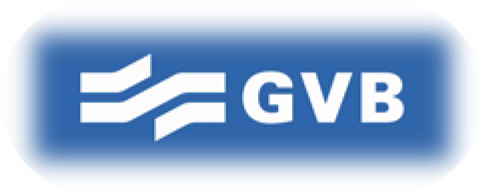

In [45]:
json_data = json.loads(zf.read('structuredData.json'))

# Find the first table in the JSON data
tables = []
for element in json_data['elements']:
    if element['Path'].endswith('/Table'):
        tables.append(element)

import pandas as pd

if tables:
    first_table = tables[0]
    excel_path = first_table['filePaths'][0]  # Gets 'tables/fileoutpart3.xlsx'

    # Read the Excel file directly from the ZIP archive
    with zf.open(excel_path) as excel_file:
        df = pd.read_excel(excel_file)
        print("\nTable contents:")
        print(df.to_dict())


# Find the first image in the JSON data
images = []
for element in json_data['elements']:
    if element['Path'].endswith('/Figure'):
        images.append(element)

if images:
    first_image = images[0]
    image_path = first_image['filePaths'][0]  # Gets path like 'figures/figure1.png'

    # Read the image file directly from the ZIP archive
    with zf.open(image_path) as image_file:
        image_data = image_file.read()
        # Display the image and bounding box
        from IPython.display import Image, display
        print("Image bounding box:", first_image['Bounds'])
        display(Image(image_data))


In [47]:
def determine_element_type(element):
    """Helper function to determine the actual type based on available content"""
    path = element.get('Path', '').lower()

    # Print debug info
    if '/figure' in path:
        print(f"Found figure element: {element}")

    # Check for Text elements first - most common
    if '/text' in path or '/h1' in path or '/p' in path or '/l' in path or '/lbl' in path or '/lbody' in path:
        return 'text'

    # Check for tables - need both path and file
    if '/table' in path:
        if 'filePaths' in element and any(fp.endswith('.xlsx') for fp in element['filePaths']):
            return 'table'
        return 'text'  # Table without data file is likely just text/caption

    # Check for images - need both path and file
    if '/figure' in path:
        if 'filePaths' in element and element['filePaths']:  # Just check if filePaths exists and is non-empty
            return 'image'
        print(f"Figure without image file: {element}")  # Debug print
        return 'text'  # Figure without image file is likely just a caption

    return None

def create_structured_output(json_data, zf):
    """Creates structured JSON output from parsed document data"""
    output = []
    page_elements = {}  # Group elements by page

    # Debug print total elements
    print(f"Total elements: {len(json_data['elements'])}")

    for element in json_data['elements']:
        page_num = element.get('Page', 0)
        if page_num not in page_elements:
            page_elements[page_num] = []

        # Handle bounds
        bounds = element.get('Bounds', [0, 0, 0, 0])
        if isinstance(bounds, list) and len(bounds) >= 4:
            x1, y1, x2, y2 = bounds[0], bounds[1], bounds[2], bounds[3]
        else:
            x1, y1, x2, y2 = 0, 0, 0, 0

        element_type = determine_element_type(element)
        print(element_type, element.get('Path', '').lower(), page_num)

        if element_type == 'table':
            try:
                excel_path = element['filePaths'][0]
                with zf.open(excel_path) as excel_file:
                    df = pd.read_excel(excel_file)
                    table_data = {
                        "headers": df.columns.tolist(),
                        "data": df.values.tolist()
                    }
            except Exception as e:
                print(f"Error processing table: {e}")
                table_data = {"headers": [], "data": []}

            structured_element = {
                "type": "table",
                "boundingBox": {
                    "x1": x1, "x2": x2, "y1": y1, "y2": y2
                },
                "table": table_data,
                "page": page_num
            }

        elif element_type == 'image':
            image_path = element['filePaths'][0]
            structured_element = {
                "type": "image",
                "boundingBox": {
                    "x1": x1, "x2": x2, "y1": y1, "y2": y2
                },
                "imagePath": image_path,
                "text": element.get('Text', ''),
                "page": page_num
            }

        elif element_type == 'text':
            structured_element = {
                "type": "text",
                "boundingBox": {
                    "x1": x1, "x2": x2, "y1": y1, "y2": y2
                },
                "text": element.get('Text', ''),
                "page": page_num
            }

        else:
            continue

        page_elements[page_num].append(structured_element)

    # Debug print elements found per page
    # for page_num, elements in page_elements.items():
    #     print(f"Page {page_num}: {len(elements)} elements found")
    #     print(f"Images on page {page_num}: {sum(1 for e in elements if e['type'] == 'image')}")

    # Flatten while maintaining page order
    output = []
    for page_num in sorted(page_elements.keys()):
        output.extend(page_elements[page_num])

    return output

# Usage
json_data = json.loads(zf.read('structuredData.json'))
structured_output = create_structured_output(json_data, zf)

print('')

# Print or save output
# print(json.dumps(structured_output, indent=4))

Total elements: 525
Found figure element: {'Bounds': [56.649993896484375, 760.1799926757812, 172.89999389648438, 806.7799987792969], 'ObjectID': 1398, 'Page': 0, 'Path': '//Document/Figure', 'attributes': {'BBox': [56.63769999999931, 760.2029999999795, 172.9129999999932, 806.7609999999986], 'Placement': 'Block'}, 'filePaths': ['figures/fileoutpart0.png']}
image //document/figure 0
text //document/h1 0
Found figure element: {'Bounds': [57.05999755859375, 640.3273620605469, 121.80325317382812, 704.1177978515625], 'ObjectID': 1400, 'Page': 0, 'Path': '//Document/Figure[2]', 'attributes': {'BBox': [56.997699999999895, 640.5679999999993, 121.67499999999927, 704.1659999999974], 'Placement': 'Block'}, 'filePaths': ['figures/fileoutpart1.png']}
image //document/figure[2] 0
text //document/p 0
text //document/h1[2] 0
Found figure element: {'Bounds': [56.649993896484375, 519.1300048828125, 366.0, 600.7299957275391], 'ObjectID': 1403, 'Page': 0, 'Path': '//Document/Figure[3]', 'attributes': {'BBo

In [35]:
# Usage
json_data = json.loads(zf.read('structuredData.json'))
print("Initial JSON structure:")
print(json_data)  # This will help us see the actual structure

structured_output = create_structured_output(json_data, zf)

print(json.dumps(structured_output, indent=4))


Initial JSON structure:
{'version': {'json_export': '218', 'page_segmentation': '55', 'schema': '1.1.0', 'structure': '1.1136.0', 'table_structure': '5'}, 'extended_metadata': {'ID_instance': '19 4C DB FE 03 BC B2 11 0A 00 F3 3E A7 56 B6 4C ', 'ID_permanent': '75 CF 1E 90 1F 6B 21 45 B9 36 E8 C3 DE 35 2F 31 ', 'has_acroform': False, 'has_embedded_files': False, 'is_XFA': False, 'is_certified': False, 'is_encrypted': False, 'is_digitally_signed': False, 'language': 'nl-NL', 'page_count': 33, 'pdf_version': '1.7', 'pdfa_compliance_level': '', 'pdfua_compliance_level': ''}, 'elements': [{'Bounds': [56.649993896484375, 760.1799926757812, 172.89999389648438, 806.7799987792969], 'ObjectID': 1398, 'Page': 0, 'Path': '//Document/Figure', 'attributes': {'BBox': [56.63769999999931, 760.2029999999795, 172.9129999999932, 806.7609999999986], 'Placement': 'Block'}, 'filePaths': ['figures/fileoutpart0.png']}, {'Bounds': [56.48249816894531, 713.1840972900391, 107.76921081542969, 723.8546142578125], 'F